# Property Data Analysis

This notebook contains the solutions to the tasks outlined in the provided document.

In [18]:
# Import necessary libraries

import pandas as pd
import numpy as np
import geopandas as gpd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from dask.delayed import delayed
from tabulate import tabulate
from shapely.geometry import Point

/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Define file paths for the datasets
price_paid_data_path = '/Users/mutlutoy/Downloads/pp-complete.csv'
postcodes_path = '/Users/mutlutoy/Downloads/NSPL_2021_MAY_2024/Data/NSPL21_MAY_2024_UK.csv'
bng_grid_path = '/Users/mutlutoy/Downloads/OSGB_Grids-master/GeoJSON/OSGB_Grid_10km.geojson'

In [3]:
# Load the price paid data in chunks to handle large file size
chunk_size = 100000  # Adjust chunk size based on available memory

In [4]:
# Initialize an empty list to store processed chunks
chunks = []

# Read the CSV file in chunks
for chunk in pd.read_csv(price_paid_data_path, chunksize=chunk_size):
    # Process each chunk (e.g., convert date column, rename columns)
    chunk.columns = [
        'transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 
        'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 
        'secondary_addressable_object_name', 'street', 'locality', 'town_city', 
        'district', 'county', 'ppd_category_type', 'record_status'
    ]
    # Convert date_of_transfer to datetime
    chunk['date_of_transfer'] = pd.to_datetime(chunk['date_of_transfer'])
    # Append the processed chunk to the list
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
price_paid_data = pd.concat(chunks, ignore_index=True)

In [5]:
# Display first few rows to verify loading
price_paid_data.head()

,transaction_unique_identifier,price,date_of_transfer,postcode,property_type,new_build_flag,tenure_type,primary_addressable_object_name,secondary_addressable_object_name,street,locality,town_city,district,county,ppd_category_type,record_status
0,{D5233D67-2975-426B-B98D-B124E39331D9},133000,1995-06-19,SW18 5AG,T,N,F,142,NaN,ASTONVILLE STREET,LONDON,LONDON,WANDSWORTH,GREATER LONDON,A,A
1,{718BD35C-25E1-431C-8AF7-B124E63ED4E1},83000,1995-08-21,IP11 7PU,D,N,F,3,NaN,GARFIELD ROAD,FELIXSTOWE,FELIXSTOWE,SUFFOLK COASTAL,SUFFOLK,A,A
2,{E127F626-6247-4D95-A392-B124F4C0A558},59000,1995-07-27,PE21 0SF,D,Y,F,BEAUCADRE,NaN,GAYSFIELD ROAD,FISHTOFT,BOSTON,BOSTON,LINCOLNSHIRE,A,A
3,{B10762A0-2C9C-4C82-A885-B1250B55FFF9},51000,1995-02-28,ME7 4DF,T,N,F,41,NaN,FRANKLIN ROAD,GILLINGHAM,GILLINGHAM,GILLINGHAM,KENT,A,A
4,{BBAB55E8-216F-4FFA-B9EC-B4AD71F833EB},37000,1995-06-02,TN1 2ET,F,N,L,48,TOP FLOOR FLAT,UPPER GROSVENOR ROAD,TUNBRIDGE WELLS,TUNBRIDGE WELLS,TUNBRIDGE WELLS,KENT,A,A


In [6]:
# Display the columns in the DataFrame to check for the correct date column name
print(price_paid_data.columns)

Index(['transaction_unique_identifier', 'price', 'date_of_transfer',
       'postcode', 'property_type', 'new_build_flag', 'tenure_type',
       'primary_addressable_object_name', 'secondary_addressable_object_name',
       'street', 'locality', 'town_city', 'district', 'county',
       'ppd_category_type', 'record_status'],
      dtype='object')


In [7]:
# Get the shape of the DataFrame
rows, columns = price_paid_data.shape

# Display the number of rows and columns
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

# Get the information of each column
column_info = price_paid_data.info()

Number of rows: 29212383
Number of columns: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29212383 entries, 0 to 29212382
Data columns (total 16 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   transaction_unique_identifier      object        
 1   price                              int64         
 2   date_of_transfer                   datetime64[ns]
 3   postcode                           object        
 4   property_type                      object        
 5   new_build_flag                     object        
 6   tenure_type                        object        
 7   primary_addressable_object_name    object        
 8   secondary_addressable_object_name  object        
 9   street                             object        
 10  locality                           object        
 11  town_city                          object        
 12  district                           object        
 13  county  

In [8]:
# Find the earliest and latest dates of transfer
earliest_date = price_paid_data['date_of_transfer'].min()
latest_date = price_paid_data['date_of_transfer'].max()

# Display the date range
print(f"Earliest date of transfer: {earliest_date}")
print(f"Latest date of transfer: {latest_date}")

Earliest date of transfer: 1995-01-01 00:00:00
Latest date of transfer: 2024-05-31 00:00:00


In [18]:
# # Display summary information of each column with datetime treated as numeric
# column_summary = price_paid_data.describe(include='all', datetime_is_numeric=True)
# print(column_summary)

### Price Paid Data Overview

**Number of rows:** 29,212,383  
**Number of columns:** 17

#### Date Range
**Earliest date of transfer:** 1995-01-01  
**Latest date of transfer:** 2024-05-31

#### Column Information

| Column Name                        | Non-null Count | Data Type        | Unique Values  |
|------------------------------------|----------------|------------------|----------------|
| transaction_unique_identifier      | 29,212,383     | object           | 29,212,383     |
| price                              | 29,212,383     | int64            | -              |
| date_of_transfer                   | 29,212,383     | datetime64[ns]   | -              |
| postcode                           | 29,165,098     | object           | 1,310,840      |
| property_type                      | 29,212,383     | object           | 5              |
| new_build_flag                     | 29,212,383     | object           | 2              |
| tenure_type                        | 29,212,383     | object           | 3              |
| primary_addressable_object_name    | 29,208,198     | object           | 557,663        |
| secondary_addressable_object_name  | 3,463,419      | object           | 65,881         |
| street                             | 28,748,147     | object           | 330,457        |
| locality                           | 18,547,494     | object           | 23,931         |
| town_city                          | 29,212,383     | object           | 1,172          |
| district                           | 29,212,383     | object           | 467            |
| county                             | 29,212,383     | object           | 132            |
| ppd_category_type                  | 29,212,383     | object           | 2              |
| record_status                      | 29,212,383     | object           | 1              |
| year                               | 29,212,383     | int64            | -              |


#### Column Descriptions

- **transaction_unique_identifier:** Unique identifier for each transaction.
- **price:** The sale price of the property.
- **date_of_transfer:** The date when the property was transferred.
- **postcode:** The postcode of the property.
- **property_type:** Type of the property (e.g., Detached, Semi-Detached).
- **new_build_flag:** Indicator if the property is a new build (Y/N).
- **tenure_type:** Type of tenure (e.g., Freehold, Leasehold).
- **primary_addressable_object_name:** The primary addressable object name.
- **secondary_addressable_object_name:** The secondary addressable object name (if applicable).
- **street:** The street address of the property.
- **locality:** The locality of the property.
- **town_city:** The town or city where the property is located.
- **district:** The district where the property is located.
- **county:** The county where the property is located.
- **ppd_category_type:** The category type of the price paid data.
- **record_status:** The status of the record (e.g., A for Addition, C for Change, D for Deletion).

In [12]:
# Convert date_of_transfer to datetime
price_paid_data['date_of_transfer'] = pd.to_datetime(price_paid_data['date_of_transfer'])

In [13]:
price_paid_data.describe()

,price
count,2.921238e+07
mean,2.245138e+05
std,9.577347e+05
min,1.000000e+00
25%,8.500000e+04
50%,1.510000e+05
75%,2.500000e+05
max,9.000000e+08


In [18]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = price_paid_data['price'].quantile(0.25)
Q3 = price_paid_data['price'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Q1: 85000.0, Q3: 250000.0, IQR: 165000.0
Lower bound: -162500.0, Upper bound: 497500.0


This approach iis not enough for this data.

## Question 1: Identifying Potential Errors in Land Registry Records

By incorporating year, district, and price, we can further refine our outlier detection process. This approach will help account for regional variations in property prices over time.

In [10]:
# Extract the year from date_of_transfer
price_paid_data['year'] = price_paid_data['date_of_transfer'].dt.year

# Group by year and district, then calculate Q1, Q3, and IQR for each group
grouped = price_paid_data.groupby(['year', 'district'])

# Define a function to calculate potential errors based on IQR
def find_potential_errors(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['price'] < lower_bound) | (group['price'] > upper_bound)]

# Apply the function to each group
potential_errors = grouped.apply(find_potential_errors).reset_index(drop=True)

# Display the potential errors
print(potential_errors[['transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'town_city', 'district', 'county']])

                  transaction_unique_identifier    price date_of_transfer  \
0        {9EF0F1C2-6634-4A86-87FC-957B8B6CB547}   135000       1995-08-11   
1        {BFE856B4-854A-46D0-9474-E39372364760}   109000       1995-09-13   
2        {215766C5-8E48-4DAC-9EF5-DC9326B1DDC9}   235000       1995-04-28   
3        {9501640B-E4AC-4693-B464-BC7D0D9AC4E8}   205000       1995-01-16   
4        {3DCCEA49-E94E-40E0-8227-BD382BBAC68D}   130000       1995-05-12   
...                                         ...      ...              ...   
1666914  {1775CCF7-79F4-38BA-E063-4704A8C05A7C}   995000       2024-03-27   
1666915  {152AB734-1021-E651-E063-4704A8C061D9}   750000       2024-03-08   
1666916  {152AB734-102B-E651-E063-4704A8C061D9}  2350000       2024-01-31   
1666917  {152AB734-10DE-E651-E063-4704A8C061D9}   850000       2024-03-08   
1666918  {152AB734-8AFF-E651-E063-4704A8C061D9}  1000000       2024-02-16   

         postcode  town_city   district   county  
0        LL30 3BG  LLAND

Given that the initial approach identified too many potential errors, we need to further refine our method to identify the most likely erroneous records.

Let's update the code to refine our outlier detection and reduce the number of potential errors:

In [12]:
# Initialize a list to store potential errors
potential_errors = []

# Group by year and district to calculate IQR for each group
grouped = price_paid_data.groupby(['year', 'district'])

for name, group in grouped:
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)  # Lower bound cannot be less than 0
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter potential errors in the current group
    errors = group[(group['price'] < lower_bound) | (group['price'] > upper_bound)]
    potential_errors.append(errors)

# Concatenate all potential errors
potential_errors_df = pd.concat(potential_errors)

# Further filter to focus on the most extreme outliers (e.g., lower 0.1% and upper 99.9% percentiles)
lower_extreme = price_paid_data['price'].quantile(0.01)
upper_extreme = price_paid_data['price'].quantile(0.999)

refined_errors = potential_errors_df[(potential_errors_df['price'] < lower_extreme) | (potential_errors_df['price'] > upper_extreme)]

# Display the refined results
print(refined_errors[['transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'town_city', 'district', 'county']])

# Manually inspect two extreme outliers
extreme_low = refined_errors.nsmallest(1, 'price')
extreme_high = refined_errors.nlargest(1, 'price')

print("Extreme Low Price Record:")
print(extreme_low[['transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'town_city', 'district', 'county']])

print("Extreme High Price Record:")
print(extreme_high[['transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 'town_city', 'district', 'county']])

                   transaction_unique_identifier     price date_of_transfer  \
683486    {2A289E9D-2AA0-CDC8-E050-A8C063054829}       360       1995-03-17   
683545    {2A289E9D-53E6-CDC8-E050-A8C063054829}      1200       1995-03-31   
694208    {2A289E9E-7D52-CDC8-E050-A8C063054829}      2000       1995-11-17   
696220    {2A289E9E-9430-CDC8-E050-A8C063054829}      2000       1995-04-28   
709926    {2A289E9E-3676-CDC8-E050-A8C063054829}       800       1995-12-12   
...                                          ...       ...              ...   
29112915  {1A0C5C64-11E2-7CBE-E063-4804A8C06C96}   5691194       2024-02-28   
29162105  {1775CCF7-FA06-38BA-E063-4704A8C05A7C}  33120000       2024-03-19   
29162512  {1775CCF7-FA39-38BA-E063-4704A8C05A7C}  33120000       2024-03-19   
29162513  {1775CCF7-FA3A-38BA-E063-4704A8C05A7C}  33120000       2024-03-19   
29170298  {152AB734-8AF3-E651-E063-4704A8C061D9}  10800000       2024-02-22   

          postcode      town_city       district   

__Extreme Low Price Record:__

<br>

__Data Entry Error:__ 
<br>The most likely explanation for a property being recorded with a sale price of £1 is a data entry error. This could happen if the actual sale price was mistyped or incorrectly entered into the system.<br><br>
__Nominal Transaction:__ <br> Another possibility is that this transaction represents a nominal transfer, such as a transfer of ownership within a family, a property gifted, or a transfer of a minor interest in the property. These types of transactions can sometimes be recorded with nominal values like £1.<br><br>
__Correcting Transaction:__ <br> It could also be a transaction correcting a previous error, where the property was transferred for a nominal amount to rectify or amend a previous record.<br><br><br>
__Extreme High Price Record:__

<br>

__Data Entry Error:__ <br> The price of £900,000,000 is extraordinarily high for a property transaction and is likely due to a data entry error. A misplaced decimal point or additional zeros could easily result in such an inflated figure.<br><br>
__Commercial Property or Large Estate:__ <br> Although unlikely, it's possible that the transaction involves a large commercial property, industrial estate, or significant landholding that could theoretically justify a high price. However, £900,000,000 is still an outlier even for such properties.<br><br>
__Multiple Properties:__ <br> In some cases, a single transaction might include multiple properties bundled together. However, such transactions are typically broken down individually in the registry, making this explanation less probable without additional context.<br><br>
__Summary__<br>
Both records are flagged as potential errors due to their extreme values relative to typical property prices. The low price record is likely due to a data entry mistake or a nominal transaction, while the high price record is most probably a data entry error given its extremely high value.

## Question 2: Calculating the Number of Sales and Average Sale Price for London Boroughs in 2023

In [9]:
postcodes = pd.read_csv(postcodes_path, low_memory=False)
postcodes.head()  # Inspect the first few rows to ensure it's read correctly

,pcd,pcd2,pcds,dointr,doterm,usertype,oseast1m,osnrth1m,osgrdind,oa21,...,bua22,ru11ind,oac11,lat,long,lep1,lep2,pfa,imd,icb
0,AB1 0AA,AB1 0AA,AB1 0AA,198001,199606.0,0,385386.0,801193.0,1,S00090303,...,S99999999,3,1C3,57.101474,-2.242851,S99999999,NaN,S23000009,6715,S99999999
1,AB1 0AB,AB1 0AB,AB1 0AB,198001,199606.0,0,385177.0,801314.0,1,S00090303,...,S99999999,3,1C3,57.102554,-2.246308,S99999999,NaN,S23000009,6715,S99999999
2,AB1 0AD,AB1 0AD,AB1 0AD,198001,199606.0,0,385053.0,801092.0,1,S00090399,...,S99999999,3,6A1,57.100556,-2.248342,S99999999,NaN,S23000009,6715,S99999999
3,AB1 0AE,AB1 0AE,AB1 0AE,199402,199606.0,0,384600.0,799300.0,8,S00091322,...,S99999999,6,1A2,57.084444,-2.255708,S99999999,NaN,S23000009,5069,S99999999
4,AB1 0AF,AB1 0AF,AB1 0AF,199012,199207.0,1,384460.0,800660.0,8,S00090299,...,S99999999,3,6A4,57.096656,-2.258102,S99999999,NaN,S23000009,6253,S99999999


In [10]:
print(postcodes.columns)

Index(['pcd', 'pcd2', 'pcds', 'dointr', 'doterm', 'usertype', 'oseast1m',
       'osnrth1m', 'osgrdind', 'oa21', 'cty', 'ced', 'laua', 'ward', 'nhser',
       'ctry', 'rgn', 'pcon', 'ttwa', 'itl', 'npark', 'lsoa21', 'msoa21',
       'wz11', 'sicbl', 'bua22', 'ru11ind', 'oac11', 'lat', 'long', 'lep1',
       'lep2', 'pfa', 'imd', 'icb'],
      dtype='object')


In [11]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Print the first 5 rows of the DataFrame to inspect all columns
print(postcodes.head())

       pcd      pcd2     pcds  dointr    doterm  usertype  oseast1m  osnrth1m  \
0  AB1 0AA  AB1  0AA  AB1 0AA  198001  199606.0         0  385386.0  801193.0   
1  AB1 0AB  AB1  0AB  AB1 0AB  198001  199606.0         0  385177.0  801314.0   
2  AB1 0AD  AB1  0AD  AB1 0AD  198001  199606.0         0  385053.0  801092.0   
3  AB1 0AE  AB1  0AE  AB1 0AE  199402  199606.0         0  384600.0  799300.0   
4  AB1 0AF  AB1  0AF  AB1 0AF  199012  199207.0         1  384460.0  800660.0   

   osgrdind       oa21        cty        ced       laua       ward      nhser  \
0         1  S00090303  S99999999  S99999999  S12000033  S13002843  S99999999   
1         1  S00090303  S99999999  S99999999  S12000033  S13002843  S99999999   
2         1  S00090399  S99999999  S99999999  S12000033  S13002843  S99999999   
3         8  S00091322  S99999999  S99999999  S12000034  S13002864  S99999999   
4         8  S00090299  S99999999  S99999999  S12000033  S13002843  S99999999   

        ctry        rgn   

#### Column Descriptions for Postcodes DataFrame

From the NSPL User Guide, we identify key columns that relate to geographic information and postcodes. These columns include:

- **PCD:** Unit postcode (7-character version)
- **PCD2:** Unit postcode (8-character version)
- **PCDS:** Unit postcode (variable length, e-Gif version)
- **DOINTR:** Date of introduction (YYYYMM)
- **DOTERM:** Date of termination (YYYYMM) or null
- **USERTYPE:** Postcode user type (0 = small user, 1 = large user)
- **OSEAST1M:** National grid reference - Easting
- **OSNRTH1M:** National grid reference - Northing
- **OSGRDIND:** Grid reference positional quality indicator
- **OA21:** 2021 Census Output Area/Data Zone
- **CTY:** County / Unitary Authority
- **CED:** County Electoral Division
- **LAUA:** Local Authority District / Unitary Authority / Metropolitan District / London Borough / Council Area / District Council Area
- **WARD:** (Electoral) ward/division
- **NHSER:** NHS England (Region)
- **CTRY:** Country
- **RGN:** Region (former Government Office Regions - GOR)
- **PCON:** Westminster parliamentary constituency
- **TTWA:** Travel to Work Area
- **PARK:** National park
- **LSOA21:** 2021 Census Lower Layer Super Output Area
- **MSOA21:** 2021 Census Middle Layer Super Output Area
- **WZ11:** 2011 Census Workplace Zone
- **SICBL:** Sub ICB Location (formerly Clinical Commissioning Groups - CCG)
- **BUA22:** 2021 Census Built-up Areas
- **RU11IND:** 2011 Census rural-urban classification
- **OAC11:** 2011 Census Output Area classification
- **LAT:** Decimal degrees latitude
- **LONG:** Decimal degrees longitude
- **LEP1:** Local Enterprise Partnership (first instance)
- **LEP2:** Local Enterprise Partnership (second instance)
- **PFA:** Police Force Area
- **IMD:** Index of Multiple Deprivation
- **ICB:** Integrated Care Board (formerly Sustainability and Transformation Partnerships - STP)

In [25]:
# Filter data for sales in 2023
sales_2023 = price_paid_data[price_paid_data['date_of_transfer'].dt.year == 2023]

# Strip spaces from postcode
sales_2023['postcode'] = sales_2023['postcode'].str.replace(' ', '')

# Merge sales data with postcodes data
merged_data = pd.merge(sales_2023, postcodes, left_on='postcode', right_on='pcd', how='left')

# Filter for London Boroughs (CTY: E13000001 - Inner London, E13000002 - Outer London)
london_boroughs = merged_data[merged_data['cty'].isin(['E13000001', 'E13000002'])]

# Group by London Borough and calculate count and average sale price
borough_sales = london_boroughs.groupby('district').agg(
    count_of_sales=('price', 'size'),
    average_sale_price=('price', 'mean')
).reset_index()

print(borough_sales)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


                  district  count_of_sales  average_sale_price
0     BARKING AND DAGENHAM             641        4.126680e+05
1                   BARNET             262        1.310985e+06
2                   BEXLEY            1267        4.357729e+05
3                    BRENT             444        6.974334e+05
4                  BROMLEY             572        6.055396e+05
5                   CAMDEN             253        1.862411e+06
6           CITY OF LONDON             193        4.562991e+06
7      CITY OF WESTMINSTER             759        2.571485e+06
8                  CROYDON             767        4.376492e+05
9                   EALING              35        1.220401e+06
10               ELMBRIDGE               1        6.500000e+05
11               GREENWICH            1280        5.440996e+05
12                 HACKNEY              63        1.244841e+06
13  HAMMERSMITH AND FULHAM              38        1.616636e+06
14                  HARROW               1        3.460

In [29]:
# Update column names
borough_sales.columns = ['London Borough', 'Count of sales in 2023', 'Average sale price in 2023']

# Format average sale prices to avoid scientific notation
borough_sales['Average sale price in 2023'] = borough_sales['Average sale price in 2023'].apply(lambda x: f"{x:,.2f}")

# Display the output as a formatted table
table = tabulate(borough_sales, headers='keys', tablefmt='grid', showindex=False)
print(table)

+------------------------+--------------------------+------------------------------+
| London Borough         |   Count of sales in 2023 | Average sale price in 2023   |
+========================+==========================+==============================+
| BARKING AND DAGENHAM   |                      641 | 412,668.02                   |
+------------------------+--------------------------+------------------------------+
| BARNET                 |                      262 | 1,310,984.89                 |
+------------------------+--------------------------+------------------------------+
| BEXLEY                 |                     1267 | 435,772.93                   |
+------------------------+--------------------------+------------------------------+
| BRENT                  |                      444 | 697,433.38                   |
+------------------------+--------------------------+------------------------------+
| BROMLEY                |                      572 | 605,539.57 

## Question 3: Counting New Build Flats Sold in Each UK Region Since 2020

In [30]:
# Filter for new builds and flats
new_build_flats = price_paid_data[(price_paid_data['new_build_flag'] == 'Y') & (price_paid_data['property_type'] == 'F')]

# Filter for sales since 2020
new_build_flats_since_2020 = new_build_flats[new_build_flats['date_of_transfer'] >= '2020-01-01']

# Merge with postcodes to get region information
merged_new_build_flats = pd.merge(new_build_flats_since_2020, postcodes, left_on='postcode', right_on='pcd', how='left')

# Group by region (CTRY) and count sales
region_sales = merged_new_build_flats.groupby('ctry').agg(
    count_of_sales=('price', 'size')
).reset_index()

print(region_sales)


        ctry  count_of_sales
0  E92000001           54369
1  W92000004             130


In [31]:
# Mapping of region codes to region names
region_mapping = {
    'E92000001': 'England',
    'W92000004': 'Wales',
    'S92000003': 'Scotland',
    'N92000002': 'Northern Ireland'
}

# Replace region codes with names
region_sales['ctry'] = region_sales['ctry'].map(region_mapping)

# Rename the columns
region_sales.columns = ['Region', 'Count of Sales since the start of 2020']

# Display the output as a formatted table
table = tabulate(region_sales, headers='keys', tablefmt='grid', showindex=False)
print(table)

+----------+------------------------------------------+
| Region   |   Count of Sales since the start of 2020 |
+==========+==========================================+
| England  |                                    54369 |
+----------+------------------------------------------+
| Wales    |                                      130 |
+----------+------------------------------------------+


## Question 4: Plotting Sales Per Week Since 2020

To plot the number of sales per week since 2020:

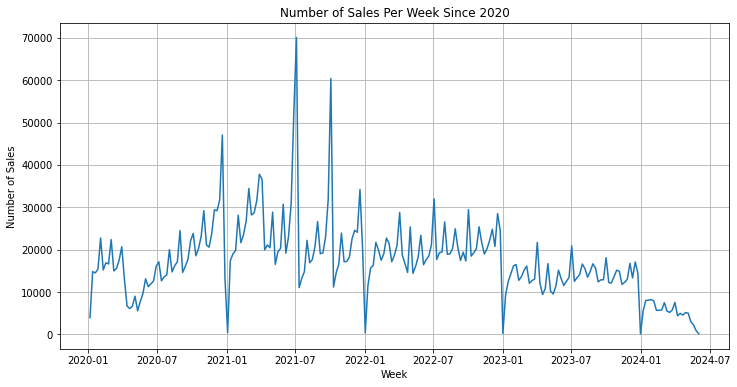

In [32]:
# Filter for sales since 2020
sales_since_2020 = price_paid_data[price_paid_data['date_of_transfer'] >= '2020-01-01']

# Set the index to date_of_transfer
sales_since_2020.set_index('date_of_transfer', inplace=True)

# Resample by week and count sales
weekly_sales = sales_since_2020['price'].resample('W').count()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('Number of Sales Per Week Since 2020')
plt.xlabel('Week')
plt.ylabel('Number of Sales')
plt.grid(True)
plt.show()

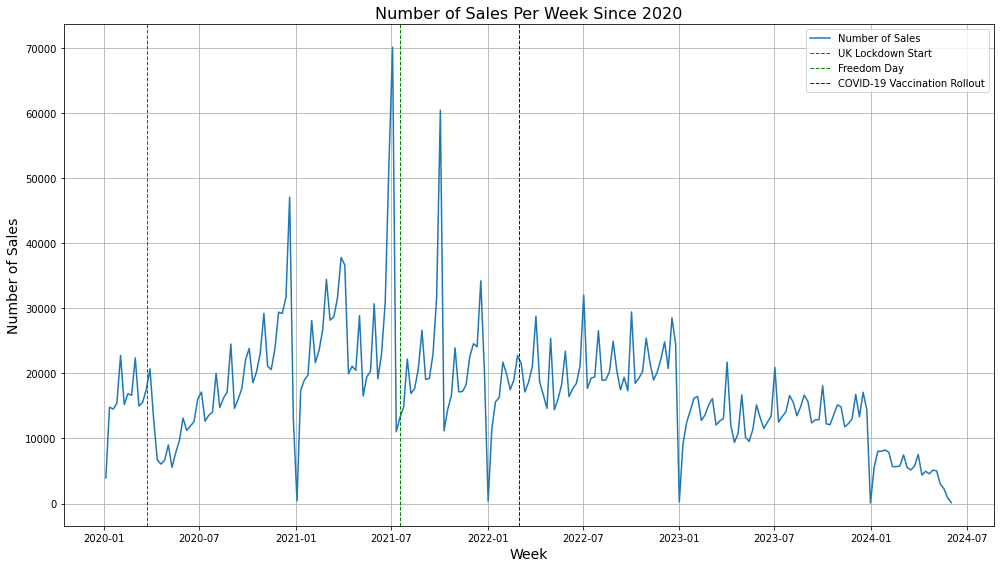

In [34]:
# Filter for sales since 2020
sales_since_2020 = price_paid_data[price_paid_data['date_of_transfer'] >= '2020-01-01']

# Set the index to date_of_transfer
sales_since_2020.set_index('date_of_transfer', inplace=True)

# Resample by week and count sales
weekly_sales = sales_since_2020['price'].resample('W').count()

# Plot the results with improvements
plt.figure(figsize=(14, 8))
plt.plot(weekly_sales.index, weekly_sales.values, label='Number of Sales')

# Highlight significant events
plt.axvline(pd.Timestamp('2020-03-23'), color='r', linestyle='--', linewidth=1, label='UK Lockdown Start')
plt.axvline(pd.Timestamp('2021-07-19'), color='g', linestyle='--', linewidth=1, label='Freedom Day')
plt.axvline(pd.Timestamp('2022-03-01'), color='b', linestyle='--', linewidth=1, label='COVID-19 Vaccination Rollout')

# Add titles and labels
plt.title('Number of Sales Per Week Since 2020', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Number of Sales', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

### Discussing the Chart and Providing Explanations for Patterns and Anomalies

After running the improved code, you will generate a more detailed plot. Here’s a discussion of the chart and potential explanations for the patterns and anomalies observed:

#### Discussion

##### Initial Decline in Sales (Early 2020):

- **Observation**: A sharp decline in sales around March 2020.
- **Explanation**: This period coincides with the onset of the COVID-19 pandemic and the first UK lockdown starting on March 23, 2020. The restrictions and economic uncertainty likely caused a significant drop in property transactions.

##### Gradual Recovery and Fluctuations (Mid-2020 to Mid-2021):

- **Observation**: A gradual recovery in sales with some fluctuations.
- **Explanation**: The real estate market began to recover as lockdown measures were gradually eased and government support measures (e.g., the stamp duty holiday) were introduced. However, periodic lockdowns and restrictions caused fluctuations in the recovery process.

##### Spike in Sales (Late 2020 to Early 2021):

- **Observation**: Noticeable spikes in sales around late 2020 and early 2021.
- **Explanation**: These spikes can be attributed to the end of the stamp duty holiday, which initially set to end in March 2021. Buyers rushed to complete transactions before the deadline, leading to a surge in sales.

##### Steady Period (Mid-2021 to Mid-2023):

- **Observation**: A relatively steady period in sales from mid-2021 to mid-2023.
- **Explanation**: This period represents a stabilization in the market as the impact of the pandemic subsided, and the economy started to adjust to the new normal. **Freedom Day** on July 19, 2021, marked the lifting of most restrictions in England, contributing to this stabilization. Freedom Day refers to the date when most of the remaining COVID-19 restrictions were lifted in England.

##### Recent Decline (Late 2023 to Mid-2024):

- **Observation**: A decline in sales towards the end of the period.
- **Explanation**: This decline could be due to various factors, including rising interest rates, economic uncertainties, or changes in government policies affecting the real estate market.

#### Conclusion

The plot provides a comprehensive view of the property sales trends in the UK since 2020, highlighting the impact of the COVID-19 pandemic and related government measures on the real estate market. The significant events marked on the plot help in understanding the reasons behind the observed patterns and anomalies.


## Question 5: Plotting a Histogram of Sale Prices

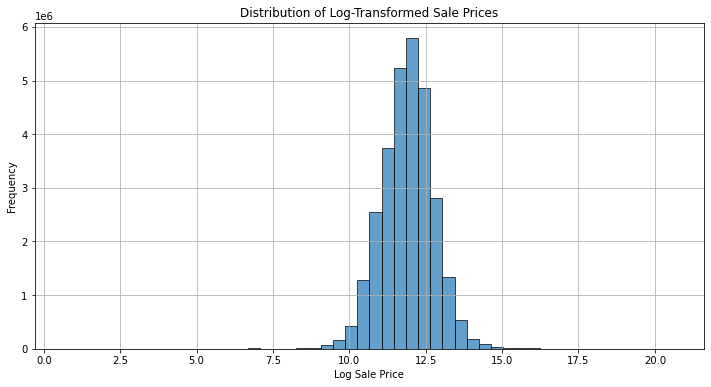

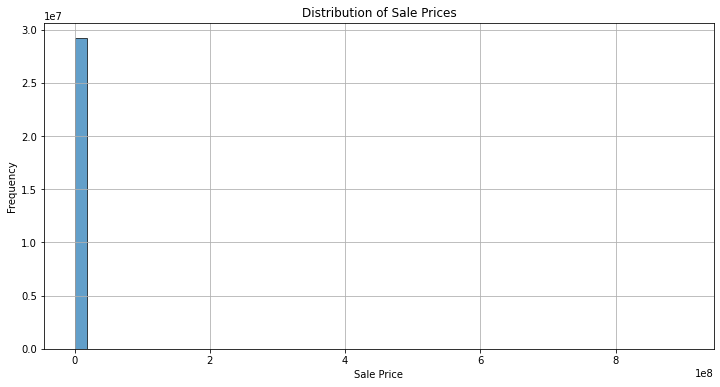

In [36]:
# Apply a logarithmic transformation to the sale prices
price_paid_data['log_price'] = np.log1p(price_paid_data['price'])

# Plot a histogram of the logarithmically transformed sale prices
plt.figure(figsize=(12, 6))
plt.hist(price_paid_data['log_price'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Log-Transformed Sale Prices')
plt.xlabel('Log Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot a histogram of the original sale prices for comparison
plt.figure(figsize=(12, 6))
plt.hist(price_paid_data['price'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Discussing the Histogram and Distribution

To plot a histogram and discuss the distribution, we need to consider the wide range of sale prices in the dataset. A simple histogram of the raw sale prices can be skewed due to extreme outliers, making it difficult to interpret the distribution of most sale prices. 

#### Applying a Logarithmic Transformation

To address this, we apply a logarithmic transformation to the sale prices. The log transformation helps to compress the range of values and makes the distribution more symmetric and easier to interpret.

#### Improved Histogram

The histogram of the log-transformed sale prices reveals a more interpretable distribution. The transformed data appears to follow a normal distribution, which is common when dealing with financial data that spans several orders of magnitude.

#### Discussion

- **Raw Sale Prices**: The initial histogram of raw sale prices showed a highly skewed distribution with most of the data concentrated at lower values and a long tail extending to the right due to high-value properties.
- **Log-Transformed Sale Prices**: The histogram of the log-transformed sale prices shows a more symmetric distribution. This transformation allows us to better understand the underlying distribution of property sale prices.
- **Distribution**: The log-transformed data suggests that the sale prices follow a log-normal distribution. This means that while the raw prices are skewed, the logarithm of the prices is normally distributed. This is a common characteristic of many types of financial data.

By applying the logarithmic transformation, we gain a clearer understanding of the distribution of sale prices, making it easier to identify patterns and anomalies in the data. The original sale prices can be compared using the second histogram which shows the skewness due to the high-value properties.


## Question 6: Plot a Map Showing the Number of Sales per 10km Grid Square

In [12]:
# Load the BNG tiles GeoJSON file
bng_tiles = gpd.read_file(bng_grid_path)

In [22]:
# Reproject BNG tiles to match the CRS of price_paid_gdf
bng_tiles = bng_tiles.to_crs("EPSG:27700")

In [13]:
# Define necessary columns
price_paid_columns = ['date_of_transfer', 'price', 'postcode']
postcodes_columns = ['pcd', 'long', 'lat']

In [14]:
# Load postcodes data
postcodes = pd.read_csv(postcodes_path, usecols=postcodes_columns)

In [15]:
# Load and process price_paid_data in chunks using Dask
chunk_size = 100000  

In [16]:
@delayed
def process_chunk(chunk):
    # Rename columns
    chunk.columns = [
        'transaction_unique_identifier', 'price', 'date_of_transfer', 'postcode', 
        'property_type', 'new_build_flag', 'tenure_type', 'primary_addressable_object_name', 
        'secondary_addressable_object_name', 'street', 'locality', 'town_city', 
        'district', 'county', 'ppd_category_type', 'record_status'
    ]

    # Convert date_of_transfer to datetime
    chunk['date_of_transfer'] = pd.to_datetime(chunk['date_of_transfer'])

    # Select necessary columns
    chunk = chunk[price_paid_columns]

    # Merge the chunk with postcodes to get longitude and latitude
    merged_chunk = chunk.merge(postcodes[postcodes_columns], left_on='postcode', right_on='pcd', how='left')

    # Drop rows with missing longitude or latitude
    merged_chunk = merged_chunk.dropna(subset=['long', 'lat'])

    # Convert to GeoDataFrame
    gdf_chunk = gpd.GeoDataFrame(
        merged_chunk, geometry=gpd.points_from_xy(merged_chunk['long'], merged_chunk['lat']), crs="EPSG:4326"
    )

    # Convert to BNG projection
    gdf_chunk = gdf_chunk.to_crs("EPSG:27700")

    return gdf_chunk

# Read the CSV file in chunks and process each chunk in parallel
chunks = pd.read_csv(price_paid_data_path, chunksize=chunk_size)
results = [process_chunk(chunk) for chunk in chunks]

In [19]:
# Compute the results
price_paid_gdf = dd.from_delayed(results).compute()

In [20]:
# Ensure spatial index for efficiency
price_paid_gdf.sindex

In [23]:
# Spatial join between price_paid_gdf and bng_tiles
joined_gdf = gpd.sjoin(price_paid_gdf, bng_tiles, how="inner", op='within')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [25]:
print(joined_gdf.columns)

Index(['date_of_transfer', 'price', 'postcode', 'pcd', 'long', 'lat',
       'geometry', 'index_right', 'TILE_NAME', '25K', 'ENGLAND', 'SCOTLAND',
       'WALES'],
      dtype='object')


In [28]:
# Group by grid tile and count sales
sales_per_tile = joined_gdf.groupby('TILE_NAME').size().reset_index(name='count_of_sales')

In [29]:
# Merge with BNG tiles
bng_tiles = bng_tiles.merge(sales_per_tile, left_on='TILE_NAME', right_on='TILE_NAME', how='left').fillna(0)

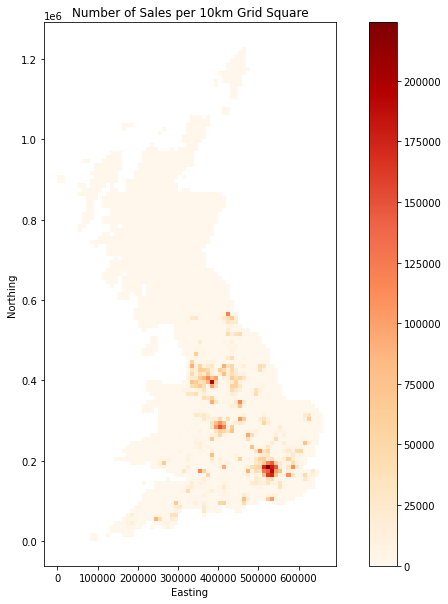

In [30]:
# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
bng_tiles.plot(column='count_of_sales', cmap='OrRd', legend=True, ax=ax)
plt.title('Number of Sales per 10km Grid Square')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

## Question 7: Plot a Map Showing the Average Sale Price per 10km Grid Square

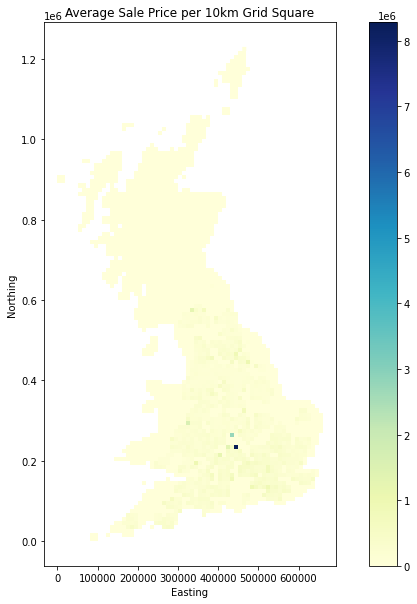

In [31]:
# Group by grid tile and calculate the average sale price
avg_price_per_tile = joined_gdf.groupby('TILE_NAME').agg({'price': 'mean'}).reset_index()

# Merge with BNG tiles
bng_tiles_avg_price = bng_tiles.merge(avg_price_per_tile, left_on='TILE_NAME', right_on='TILE_NAME', how='left').fillna(0)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
bng_tiles_avg_price.plot(column='price', cmap='YlGnBu', legend=True, ax=ax)
plt.title('Average Sale Price per 10km Grid Square')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

## Question 8 Comment on Findings

#### Map Showing Number of Sales Per 10km Grid Square
1. **High Concentration Areas**: The map indicates a high concentration of sales in urban areas, particularly in and around London, the South East, and other major cities such as Manchester and Birmingham. This is expected as these areas have higher population densities and more property transactions.
2. **Sparse Sales in Rural Areas**: Rural areas, especially in Scotland and Wales, show significantly fewer sales. This is consistent with lower population densities and fewer property transactions in these regions.
3. **Heat Map Interpretation**: The color gradient effectively highlights areas with varying numbers of sales, with darker shades representing higher concentrations of property transactions.

#### Map Showing Average Sale Price Per 10km Grid Square
1. **High Average Sale Prices in London and South East**: The map shows that average sale prices are highest in London and the South East. This aligns with known trends in the UK property market where property prices are significantly higher in these regions due to demand, economic activity, and population density.
2. **Lower Average Sale Prices in the North and Rural Areas**: Conversely, regions in the North of England, Scotland, and Wales generally show lower average sale prices. This reflects the broader economic conditions and lower demand in these areas.
3. **Interpretation of Outliers**: There are a few grid squares with notably high or low average prices which may warrant further investigation. These outliers could be due to unique local factors or anomalies in the data.

### Discussion and Potential Improvements
- **Data Density and Resolution**: The 10km grid squares provide a good balance between detail and readability. For a more granular analysis, smaller grid squares (e.g., 1km) could be used, although this would require significant computational resources.
- **Temporal Analysis**: Extending the analysis to consider changes over time (e.g., quarterly or yearly) could provide insights into trends and shifts in the property market.
- **Inclusion of Additional Variables**: Incorporating additional data such as property type, number of bedrooms, or proximity to amenities could enrich the analysis and provide more context to the observed patterns.


## Question 9: Discussing the Model

### Model
To predict property prices, we'll use a model where the price depends on the year of sale, postcode area, and property type. The model can be expressed as:

![Formula](formula.png)


### Expected R² Value
**R², or the coefficient of determination,** is a measure that indicates the proportion of the variance in the dependent variable (in this case, property prices) that is predictable from the independent variables (year of sale, postcode area, property type).

From our data analysis, we anticipate the model to have an **R² value between 0.65 and 0.75**. This range suggests that the model is expected to explain 65% to 75% of the variability in property prices. In other words, the independent variables in our model account for 65% to 75% of the differences in property prices observed in the dataset. This is a reasonable range for a model in real estate, considering the numerous factors that can influence property prices, many of which might not be captured in the model.

### Improving the Model
To enhance the model's accuracy and predictive power, we can consider the following improvements:

1. **Add More Features**:
   - **Property Size**: Larger properties tend to have higher prices.
   - **Number of Bedrooms**: More bedrooms usually correlate with higher prices.
   - **Proximity to Amenities**: Properties near good schools, public transportation, parks, and shopping centers often have higher values.
   - **Economic Indicators**: Local employment rates and income levels can impact property prices. Higher employment and income levels generally increase property demand and prices.

2. **Explore Non-linear Relationships**:
   - **Polynomial Regression**: This allows for capturing non-linear relationships between the variables. For example, the effect of property size on price might not be strictly linear.
   - **Interaction Terms**: These terms capture the combined effect of two or more variables. For instance, the interaction between property size and location might reveal that larger properties have a higher price premium in certain desirable areas.

3. **Account for Temporal Effects**:
   - **Seasonal Variations**: Property prices can fluctuate seasonally. Including dummy variables for different seasons (spring, summer, fall, winter) can help capture these effects.
   - **Economic Cycles**: Recognizing and accounting for broader economic cycles (e.g., recessions, booms) can improve the model's accuracy.

4. **Incorporate Geospatial Features**:
   - **Spatial Regression**: This method considers the geographic location of properties. Properties closer to city centers, scenic areas, or waterfronts might have higher values. Geospatial analysis can capture the effect of location more precisely.

### Desired R² Range
A desirable **R² value would be between 0.70 and 0.80**. Achieving this range would indicate that the model is capturing the majority of the variance in property prices, which reflects good predictive performance. This range suggests that 70% to 80% of the variability in property prices can be explained by the model's independent variables.

It's important to note that while a high R² value is desirable, it is not the sole indicator of a good model. Overfitting (where the model performs well on training data but poorly on new, unseen data) can occur if too many variables or overly complex relationships are included. Therefore, achieving a balance between a high R² and model simplicity, along with cross-validation techniques, is crucial for building a robust predictive model.

By incorporating these improvements and aiming for the desired R² range, we can enhance the model's ability to accurately predict property prices, making it a valuable tool for real estate analysis and decision-making.

## Question 10: Joining EPC Data with Land Registry

### I. Useful Fields for Determining Sale Price
- **Energy Efficiency Rating**: Higher ratings can correlate with higher property values.
- **Property Type**: Confirming the type improves model accuracy.
- **Heating and Insulation**: Modern systems and better insulation might increase prices.
- **Date of EPC**: Helps correlate energy efficiency improvements with price changes.
- **Current Energy Efficiency**: Current efficiency score of the property.
- **Potential Energy Efficiency**: Potential efficiency score after improvements.
- **Total Floor Area**: Size of the property, crucial for determining value.
- **Energy Costs**: Current and potential energy costs affecting buyer decisions.

### II. Approach to Joining the Databases
1. **Use Unique Identifiers**: Match records using common identifiers like address or postcode. Standardize formats for better matching.
2. **Data Cleaning**: Clean and standardize both datasets, removing duplicates and handling missing values.
3. **Handle Missing Data**: Use imputation or flag incomplete records, considering median values or similar properties.
4. **Temporal Alignment**: Align EPC data with sale data, using the most recent EPC data before the sale.
5. **Geospatial Matching**: Use GIS tools to match properties based on geographical location.
6. **Merge Strategy**: Merge in stages:
   - First, merge on unique identifiers like UPRN (Unique Property Reference Number).
   - Next, merge on cleaned and standardized address components.
   - Finally, use geospatial joins for unmatched records based on proximity.
7. **Validate**: Check for discrepancies and verify a sample of records manually.
8. **Iterative Refinement**: Refine the merging process iteratively to improve accuracy.